#분류 모델

생존에 중요한 요인이 무엇인지 찾기

지도 학습 - 문제와 답을 주고 학습

비지도 학습 - 통계, 거리를 비교, 가까운것끼리 찾기, 군집분석,

강화학습 - 알파고,

초거대 ai, LLM - 비지도?

트랜스포머 - 디코더만 쓰는게 gpt, 인코더만 쓰는게 버트

rlhf - reinforcemnet learning human feedback

api - 유료, 데이터를 openai에 넘어감

meta - llama3 , 오픈 소스,

upstage - 김성훈 교수, 1000억 투자받음,

자체 llm개발 불가,

slm - small language model , 7억개 파라미터(파인튜닝)- 스타트업 관심분야, 800억개 파라미터,

프로젝트에서 slm으로 해도 됨


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving titanic3.csv to titanic3.csv


In [ ]:
import pandas as pd


file_path = 'titanic3.csv'
df = pd.read_csv(file_path)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [ ]:
print(df.isnull().sum())

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64


이름: 호칭조사해서 나이를 카테고리별 평균으로 적용

pclass와 fare가 중복



In [ ]:
#필요없는 열 제거
# 네임, 티켓, 바디, 홈데스티, 보트, 피클래스, 캐빈

df.drop(columns=['name','ticket','body','home.dest','boat','pclass','cabin'], inplace=True)
df.head()


,survived,sex,age,sibsp,parch,fare,embarked
0,1,female,29.00,0,0,211.3375,S
1,1,male,0.92,1,2,151.5500,S
2,0,female,2.00,1,2,151.5500,S
3,0,male,30.00,1,2,151.5500,S
4,0,female,25.00,1,2,151.5500,S


In [ ]:
#결측치 처리
#나이는 평균, 임바크는  최빈

df['age'].fillna(df['age'].mean(), inplace=True)
df['fare'].fillna(df['fare'].mean(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
# df.drop(columns=['cabin'], inplace=True)

In [ ]:
#age_group을 6개 범주로 확대
bins = [0,5,12,18,35,60,100]
labels = ['infant','child','teenager', 'young adult','adult','Senior']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
df.drop(columns=['age'], inplace=True)


In [ ]:
#fare를 3개 범주로 변환
fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['fare_group'] = pd.cut(df['fare'], bins=fare_bins, labels=fare_labels)
df.drop(columns=['fare'], inplace=True)

In [ ]:
#sibsp와 parch합쳐서 가족 규모변수 생성
df['family_size'] = df['sibsp'] + df['parch'] + 1
df.drop(columns=['sibsp','parch'], inplace=True)

In [ ]:
df

,survived,sex,embarked,age_group,fare_group,family_size
0,1,female,S,young adult,High,1
1,1,male,S,infant,High,4
2,0,female,S,infant,High,4
3,0,male,S,young adult,High,4
4,0,female,S,young adult,High,4
...,...,...,...,...,...,...
1304,0,female,C,teenager,Low,2
1305,0,female,C,young adult,Low,2
1306,0,male,C,young adult,Low,1
1307,0,male,C,young adult,Low,1


In [ ]:
#번주형 변수를 더미 변수로 변환할 열 목록
#원핫 인코딩, 레이블 인코딩
#여기서는 원핫 인코딩함 따져보고 결정
categorical_columns = ['age_group','fare_group','sex','embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column], drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('survived', axis=1)
y = df['survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))
# 0.85까지 나올수있음
#

(1047, 11) (262, 11) (1047,) (262,)
Accuracy: 0.767175572519084


#나이, 요금 범주 변화만

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
#필요없는 열 제거
# PassengerId ,Pclass , Name, Ticket, Cabin
df.drop(columns=['PassengerId' ,'Pclass' , 'Name', 'Ticket', 'Cabin'], inplace=True)
df.head()


,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,1,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,0,male,35.0,0,0,8.0500,S


In [ ]:
# 결측치 처리 - 1.나이는 평균, 임바크는  최빈
df['Age'].fillna(df['Age'].mean(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

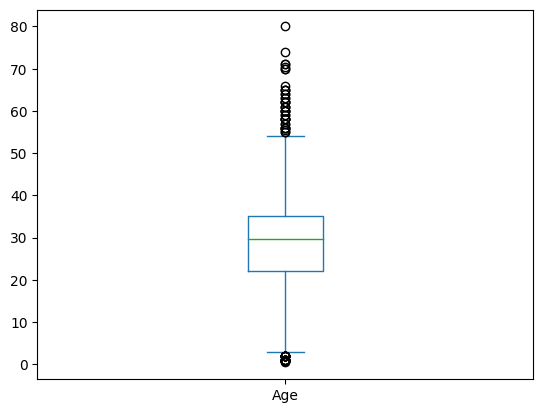

In [ ]:
#age_group 범주 결정
import matplotlib.pyplot as plt
df['Age'].plot.box()
plt.show()

In [ ]:
df['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [ ]:
#age_group을 7개 범주로 확대
bins = [0,4,12,22,29,35,55,100]
labels = ['infant','child','teenager', 'y young adult','young adult','adult','Senior']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)
df.drop(columns=['Age'], inplace=True)
df

,Survived,Sex,SibSp,Parch,Fare,Embarked,age_group
0,0,male,1,0,7.2500,S,teenager
1,1,female,1,0,71.2833,C,adult
2,1,female,0,0,7.9250,S,y young adult
3,1,female,1,0,53.1000,S,young adult
4,0,male,0,0,8.0500,S,young adult
...,...,...,...,...,...,...,...
886,0,male,0,0,13.0000,S,y young adult
887,1,female,0,0,30.0000,S,teenager
888,0,female,1,2,23.4500,S,young adult
889,1,male,0,0,30.0000,C,y young adult


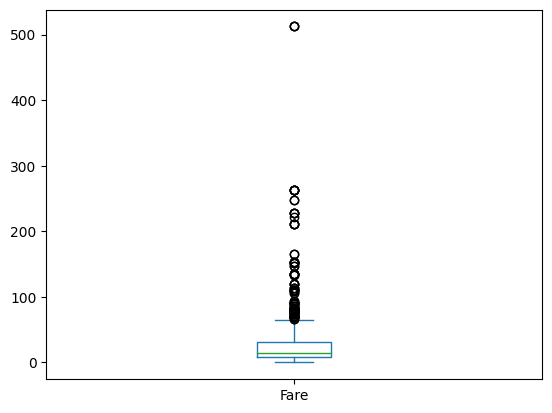

In [ ]:
#fare 범주 판단
df['Fare'].plot.box()
plt.show()

In [ ]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

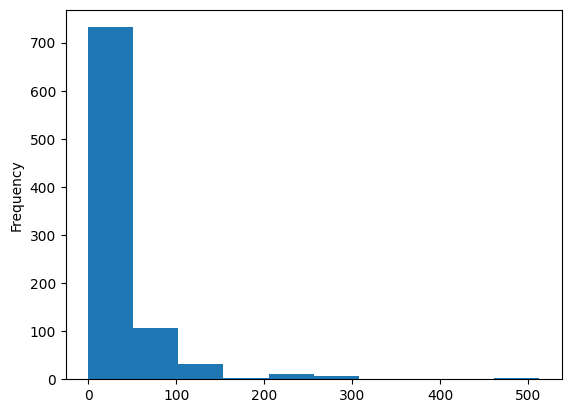

In [ ]:
df['Fare'].plot.hist()
plt.show()

In [ ]:
#fare를 5개 범주로 변환
fare_bins = [0,7,14,31,100,600]
fare_labels = ['a','b','c','d','e']
df['fare_group'] = pd.cut(df['Fare'], bins=fare_bins, labels=fare_labels)
df.drop(columns=['Fare'], inplace=True)

In [ ]:
df.head()

,Survived,Sex,SibSp,Parch,Embarked,age_group,fare_group
0,0,male,1,0,S,teenager,b
1,1,female,1,0,C,adult,d
2,1,female,0,0,S,y young adult,b
3,1,female,1,0,S,young adult,d
4,0,male,0,0,S,young adult,b


In [ ]:
#sibsp와 parch합쳐서 가족 규모변수 생성
df['family_size'] = df['SibSp'] + df['Parch'] + 1
df.drop(columns=['SibSp','Parch'], inplace=True)

In [ ]:
df.head()

,Survived,Sex,Embarked,age_group,fare_group,family_size
0,0,male,S,teenager,b,2
1,1,female,C,adult,d,2
2,1,female,S,y young adult,b,1
3,1,female,S,young adult,d,2
4,0,male,S,young adult,b,1


In [ ]:
#번주형 변수를 더미 변수로 변환할 열 목록
#원핫 인코딩, 레이블 인코딩
#여기서는 원핫 인코딩함 따져보고 결정
categorical_columns = ['age_group','fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 14) (179, 14) (712,) (179,)
Accuracy: 0.776536312849162


# 튜닝없이

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)

df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Pclass'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df.drop(columns = ['SibSp','Parch'], inplace = True)

categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 15) (179, 15) (712,) (179,)
Accuracy: 0.7932960893854749


# age 결측치 명칭에 따른 평균치로 보정, 레이블 인코딩 적용

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)
print(title_age_means)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

df['Title'].value_counts()

Title
Miss     21.773973
Mr       32.368090
Mrs      35.898148
Other    20.430161
Name: Age, dtype: float64


Title
Mr       517
Miss     182
Mrs      125
Other     67
Name: count, dtype: int64

In [12]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.773973,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,Mr


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  Title        891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


In [13]:
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)

In [14]:
df

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,male,22.000000,1,0,7.2500,S
1,1,female,38.000000,1,0,71.2833,C
2,1,female,26.000000,0,0,7.9250,S
3,1,female,35.000000,1,0,53.1000,S
4,0,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,0,male,27.000000,0,0,13.0000,S
887,1,female,19.000000,0,0,30.0000,S
888,0,female,21.773973,1,2,23.4500,S
889,1,male,26.000000,0,0,30.0000,C


In [15]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

In [16]:
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df.drop(columns = ['SibSp','Parch'], inplace = True)



In [17]:
df.head()

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size
0,0,male,S,Young Adult,Low,2
1,1,female,C,Adul,Medium,2
2,1,female,S,Young Adult,Low,1
3,1,female,S,Young Adult,Medium,2
4,0,male,S,Young Adult,Low,1


In [18]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Age_group', 'Fare_group', 'Sex', 'Embarked']

# 레이블 인코더 생성
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.head()

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size
0,0,1,2,0,1,2
1,1,0,0,1,2,2
2,1,0,2,0,1,1
3,1,0,2,0,2,2
4,0,1,2,0,1,1


In [19]:
# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 5) (179, 5) (712,) (179,)
Accuracy: 0.7932960893854749


#0604


분류 알고리즘 종류 10개

모델 구성에 다양한 방법이 있음

알고리즘별 변수 중요도 알수 있음

하이퍼 파라미터 찾기

단계별로 진행

현재 분석용 데이터셋 만드는 방법 배우는 중

지금 단계라도 탐색적 분석을 통해 인사이트를 정리는 할 수 있음



Q.점수 높이기 위한 새로운 방법

age 결측치 명칭에 따른 평균치로 보정, 원핫 인코딩 적용

In [20]:
from google.colab import files
uploaded = files.upload()

In [21]:
!ls

sample_data  train.csv


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)
print(title_age_means)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

df['Title'].value_counts()

Title
Miss     21.773973
Mr       32.368090
Mrs      35.898148
Other    20.430161
Name: Age, dtype: float64


Title
Mr       517
Miss     182
Mrs      125
Other     67
Name: count, dtype: int64

In [23]:
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)

In [24]:
df

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,male,22.000000,1,0,7.2500,S
1,1,female,38.000000,1,0,71.2833,C
2,1,female,26.000000,0,0,7.9250,S
3,1,female,35.000000,1,0,53.1000,S
4,0,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,0,male,27.000000,0,0,13.0000,S
887,1,female,19.000000,0,0,30.0000,S
888,0,female,21.773973,1,2,23.4500,S
889,1,male,26.000000,0,0,30.0000,C


In [25]:
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

In [26]:
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [28]:
df.head()

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size
0,0,male,S,Young Adult,Low,2
1,1,female,C,Adul,Medium,2
2,1,female,S,Young Adult,Low,1
3,1,female,S,Young Adult,Medium,2
4,0,male,S,Young Adult,Low,1


In [29]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [31]:
df.head()

,Survived,Family_size,Age_group_Child,Age_group_Teenager,Age_group_ Young Adult,Age_group_Adul,Age_group_Senior,Fare_group_Medium,Fare_group_High,Sex_male,Embarked_Q,Embarked_S
0,0,2,False,False,True,False,False,False,False,True,False,True
1,1,2,False,False,False,True,False,True,False,False,False,False
2,1,1,False,False,True,False,False,False,False,False,False,True
3,1,2,False,False,True,False,False,True,False,False,False,True
4,0,1,False,False,True,False,False,False,False,True,False,True


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 11) (179, 11) (712,) (179,)
Accuracy: 0.7932960893854749


age 결측치 명칭에 따른 평균치로 보정, 원핫 인코딩 적용 - 레이블 인코딩과 차이 없음

Accuracy: 0.7932960893854749

## 패미리 사이즈 제거

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)
df.drop(columns = ['SibSp','Parch'], inplace = True)

Title
Miss     21.773973
Mr       32.368090
Mrs      35.898148
Other    20.430161
Name: Age, dtype: float64


In [37]:
df.head()

,Survived,Sex,Embarked,Age_group,Fare_group
0,0,male,S,Young Adult,Low
1,1,female,C,Adul,Medium
2,1,female,S,Young Adult,Low
3,1,female,S,Young Adult,Medium
4,0,male,S,Young Adult,Low


In [38]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 10) (179, 10) (712,) (179,)
Accuracy: 0.7653631284916201


패밀리 사이즈 제거하니 점수 떨어짐

# 가족없는 경우 남자의 생존률

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] == 1) & (df['Sex'] == 'male')).astype(int)


In [42]:
df

,Survived,Sex,SibSp,Parch,Embarked,Age_group,Fare_group,Family_size,No_family_male
0,0,male,1,0,S,Young Adult,Low,2,0
1,1,female,1,0,C,Adul,Medium,2,0
2,1,female,0,0,S,Young Adult,Low,1,0
3,1,female,1,0,S,Young Adult,Medium,2,0
4,0,male,0,0,S,Young Adult,Low,1,1
...,...,...,...,...,...,...,...,...,...
886,0,male,0,0,S,Young Adult,Low,1,1
887,1,female,0,0,S,Young Adult,Low,1,0
888,0,female,1,2,S,Young Adult,Low,4,0
889,1,male,0,0,C,Young Adult,Low,1,1


In [43]:
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [44]:
df

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size,No_family_male
0,0,male,S,Young Adult,Low,2,0
1,1,female,C,Adul,Medium,2,0
2,1,female,S,Young Adult,Low,1,0
3,1,female,S,Young Adult,Medium,2,0
4,0,male,S,Young Adult,Low,1,1
...,...,...,...,...,...,...,...
886,0,male,S,Young Adult,Low,1,1
887,1,female,S,Young Adult,Low,1,0
888,0,female,S,Young Adult,Low,4,0
889,1,male,C,Young Adult,Low,1,1


In [45]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 12) (179, 12) (712,) (179,)
Accuracy: 0.7877094972067039


# Embarked 제외

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
# df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass','Embarked'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [48]:
df.head()

,Survived,Sex,Age_group,Fare_group
0,0,male,Young Adult,Low
1,1,female,Adul,Medium
2,1,female,Young Adult,Low
3,1,female,Young Adult,Medium
4,0,male,Young Adult,Low


In [49]:
categorical_columns = ['Age_group','Fare_group','Sex']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 8) (179, 8) (712,) (179,)
Accuracy: 0.7877094972067039


embark 제외시 점수 떨어짐

#가족 있는 여자의 생존률

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_female'] = ((df['Family_size'] > 1) & (df['Sex'] == 'female')).astype(int)


In [52]:
df

,Survived,Sex,SibSp,Parch,Embarked,Age_group,Fare_group,Family_size,No_family_male
0,0,male,1,0,S,Young Adult,Low,2,0
1,1,female,1,0,C,Adul,Medium,2,1
2,1,female,0,0,S,Young Adult,Low,1,0
3,1,female,1,0,S,Young Adult,Medium,2,1
4,0,male,0,0,S,Young Adult,Low,1,0
...,...,...,...,...,...,...,...,...,...
886,0,male,0,0,S,Young Adult,Low,1,0
887,1,female,0,0,S,Young Adult,Low,1,0
888,0,female,1,2,S,Young Adult,Low,4,1
889,1,male,0,0,C,Young Adult,Low,1,0


In [53]:
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [54]:
df

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size,No_family_male
0,0,male,S,Young Adult,Low,2,0
1,1,female,C,Adul,Medium,2,1
2,1,female,S,Young Adult,Low,1,0
3,1,female,S,Young Adult,Medium,2,1
4,0,male,S,Young Adult,Low,1,0
...,...,...,...,...,...,...,...
886,0,male,S,Young Adult,Low,1,0
887,1,female,S,Young Adult,Low,1,0
888,0,female,S,Young Adult,Low,4,1
889,1,male,C,Young Adult,Low,1,0


In [55]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 12) (179, 12) (712,) (179,)
Accuracy: 0.7877094972067039


가족있는 여자 넣어도 높아지지 않음


#가족 없는 남자, 가족있는 여자

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] == 1) & (df['Sex'] == 'male')).astype(int)
df['family_female'] = ((df['Family_size'] > 1) & (df['Sex'] == 'female')).astype(int)

In [58]:
df

,Survived,Sex,SibSp,Parch,Embarked,Age_group,Fare_group,Family_size,No_family_male,family_female
0,0,male,1,0,S,Young Adult,Low,2,0,0
1,1,female,1,0,C,Adul,Medium,2,0,1
2,1,female,0,0,S,Young Adult,Low,1,0,0
3,1,female,1,0,S,Young Adult,Medium,2,0,1
4,0,male,0,0,S,Young Adult,Low,1,1,0
...,...,...,...,...,...,...,...,...,...,...
886,0,male,0,0,S,Young Adult,Low,1,1,0
887,1,female,0,0,S,Young Adult,Low,1,0,0
888,0,female,1,2,S,Young Adult,Low,4,0,1
889,1,male,0,0,C,Young Adult,Low,1,1,0


In [59]:
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [60]:
df

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size,No_family_male,family_female
0,0,male,S,Young Adult,Low,2,0,0
1,1,female,C,Adul,Medium,2,0,1
2,1,female,S,Young Adult,Low,1,0,0
3,1,female,S,Young Adult,Medium,2,0,1
4,0,male,S,Young Adult,Low,1,1,0
...,...,...,...,...,...,...,...,...
886,0,male,S,Young Adult,Low,1,1,0
887,1,female,S,Young Adult,Low,1,0,0
888,0,female,S,Young Adult,Low,4,0,1
889,1,male,C,Young Adult,Low,1,1,0


In [61]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 13) (179, 13) (712,) (179,)
Accuracy: 0.7821229050279329


#가족있는 남자

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] >= 2) & (df['Sex'] == 'male')).astype(int)


In [65]:
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [66]:
df

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size,family_male
0,0,male,S,Young Adult,Low,2,1
1,1,female,C,Adul,Medium,2,0
2,1,female,S,Young Adult,Low,1,0
3,1,female,S,Young Adult,Medium,2,0
4,0,male,S,Young Adult,Low,1,0
...,...,...,...,...,...,...,...
886,0,male,S,Young Adult,Low,1,0
887,1,female,S,Young Adult,Low,1,0
888,0,female,S,Young Adult,Low,4,0
889,1,male,C,Young Adult,Low,1,0


In [67]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 12) (179, 12) (712,) (179,)
Accuracy: 0.7877094972067039


가족 있는 남자 영향 거의 없음

#가족 없는 여자

In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Title', 'Pclass'], inplace = True)
bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)


In [75]:
df.drop(columns = ['SibSp','Parch'], inplace = True)

In [76]:
df

,Survived,Sex,Embarked,Age_group,Fare_group,Family_size,No_family_female
0,0,male,S,Young Adult,Low,2,0
1,1,female,C,Adul,Medium,2,0
2,1,female,S,Young Adult,Low,1,1
3,1,female,S,Young Adult,Medium,2,0
4,0,male,S,Young Adult,Low,1,0
...,...,...,...,...,...,...,...
886,0,male,S,Young Adult,Low,1,0
887,1,female,S,Young Adult,Low,1,1
888,0,female,S,Young Adult,Low,4,0
889,1,male,C,Young Adult,Low,1,0


In [77]:
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df, columns=[column],drop_first=True)

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))      #예측 정확도

(712, 12) (179, 12) (712,) (179,)
Accuracy: 0.7988826815642458


#나이 기본, 가족없는 여자

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Pclass'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] > 1) & (df['Sex'] == 'male')).astype(int)
df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 17) (179, 17) (712,) (179,)
Accuracy: 0.7932960893854749


In [91]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] > 1) & (df['Sex'] == 'male')).astype(int)
df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8212290502793296


In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin', 'Pclass'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
# df['No_family_male'] = ((df['Family_size'] > 1) & (df['Sex'] == 'male')).astype(int)
# df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 15) (179, 15) (712,) (179,)
Accuracy: 0.7932960893854749


In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] > 1) & (df['Sex'] == 'male')).astype(int)
df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8212290502793296


In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] == 1) & (df['Sex'] == 'male')).astype(int)
df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8268156424581006


In [103]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] == 1) & (df['Sex'] == 'male')).astype(int)
df['No_family_female'] = ((df['Family_size'] == 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8268156424581006


In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['No_family_male'] = ((df['Family_size'] > 1) & (df['Sex'] == 'male')).astype(int)
df['No_family_female'] = ((df['Family_size'] > 1) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']

for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])

# 타겟 변수와 피처 변수 설정
X = df.drop('Survived', axis=1)
y = df['Survived']

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 성능 평가
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8268156424581006


In [158]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8324022346368715


In [162]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = 'train.csv'
df = pd.read_csv(file_path)


# 이름에서 타이틀 추출하는 함수 정의
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)

# 타이틀별 평균 나이 계산
title_age_means = df.groupby('Title')['Age'].mean()

# 결측치 채우기 함수 정의
def fill_age(row):
    if pd.isnull(row['Age']):
        return title_age_means[row['Title']]
    else:
        return row['Age']

# 'Age' 결측치 보정
df['Age'] = df.apply(fill_age, axis=1)

# 결측치 처리 - 2.나이는 위에서 이름별 처리, 임바크는  최빈
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)
df.drop(columns = ['Title'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
print(df.head())
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도


Title
Miss     21.773973
Mr       32.368090
Mrs      35.898148
Other    20.430161
Name: Age, dtype: float64
   Survived  Pclass     Sex Embarked     Age_group Fare_group  Family_size  \
0         0       3    male        S   Young Adult        Low            2   
1         1       1  female        C          Adul     Medium            2   
2         1       3  female        S   Young Adult        Low            1   
3         1       1  female        S   Young Adult     Medium            2   
4         0       3    male        S   Young Adult        Low            1   

   family_male  family_female  
0            0              0  
1            0              0  
2            0              0  
3            0              0  
4            0              0  
(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8100558659217877


In [174]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Ticket','Cabin'], inplace = True)
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['mr_male'] = ((df['Title'] == 'Mr')).astype(int)
# df['mrs_female'] = ((df['Title'] == 'Miss')).astype(int)
df['others'] = ((df['Title'] == 'Other')).astype(int)

df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)

df.drop(columns = ['SibSp','Parch'], inplace = True)
df.drop(columns = ['Name'], inplace = True)
df.drop(columns = ['Title'], inplace = True)
print(df.head())
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

   Survived  Pclass     Sex Embarked     Age_group Fare_group  Family_size  \
0         0       3    male        S   Young Adult        Low            2   
1         1       1  female        C          Adul     Medium            2   
2         1       3  female        S   Young Adult        Low            1   
3         1       1  female        S   Young Adult     Medium            2   
4         0       3    male        S   Young Adult        Low            1   

   family_male  mr_male  others  family_female  
0            0        1       0              0  
1            0        0       0              0  
2            0        0       0              0  
3            0        0       0              0  
4            0        1       0              0  
(712, 20) (179, 20) (712,) (179,)
Accuracy: 0.8491620111731844


In [189]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Ticket','Cabin'], inplace = True)
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,27,33,60,100]
# [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager','y y adult', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['mr_male'] = ((df['Title'] == 'Mr')).astype(int)
# df['mrs_female'] = ((df['Title'] == 'Miss')).astype(int)
df['others'] = ((df['Title'] == 'Other')).astype(int)

df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)

df.drop(columns = ['SibSp','Parch'], inplace = True)
df.drop(columns = ['Name'], inplace = True)
df.drop(columns = ['Title'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 21) (179, 21) (712,) (179,)
Accuracy: 0.8547486033519553


Q. 지금 상황에서 인사이트 발견

In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Name','Ticket','Cabin'], inplace = True)

df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)
df.drop(columns = ['SibSp','Parch'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 18) (179, 18) (712,) (179,)
Accuracy: 0.8324022346368715


In [177]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Ticket','Cabin'], inplace = True)
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['mr_male'] = ((df['Title'] == 'Mr')).astype(int)
# df['mrs_female'] = ((df['Name'] == 'Mr')).astype(int)

df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)

df.drop(columns = ['SibSp','Parch'], inplace = True)
df.drop(columns = ['Name'], inplace = True)
df.drop(columns = ['Title'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

   Survived  Pclass     Sex Embarked     Age_group Fare_group  Family_size  \
0         0       3    male        S   Young Adult        Low            2   
1         1       1  female        C          Adul     Medium            2   
2         1       3  female        S   Young Adult        Low            1   
3         1       1  female        S   Young Adult     Medium            2   
4         0       3    male        S   Young Adult        Low            1   

   family_male  mr_male  family_female  
0            0        1              0  
1            0        0              0  
2            0        0              0  
3            0        0              0  
4            0        1              0  
(712, 19) (179, 19) (712,) (179,)
Accuracy: 0.8435754189944135


In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Ticket','Cabin'], inplace = True)
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

df['Title'] = df['Name'].apply(get_title)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['mr_male'] = ((df['Title'] == 'Mr')).astype(int)
df['others'] = ((df['Title'] == 'Other')).astype(int)

df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)

df.drop(columns = ['SibSp','Parch'], inplace = True)
df.drop(columns = ['Name'], inplace = True)
df.drop(columns = ['Title'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 20) (179, 20) (712,) (179,)
Accuracy: 0.8491620111731844


#인사이트

##파생변수
- 패미리사이즈가 5명이상인 남자의 경우 추가
- 패미리사이자가 2명이상인 여자의 경우 추가
- 두 파생변수 동시 만족시 정확도 점수가 가장 높음

가족의 수가 일정이상이고,
남자와 여자의 힘의 차이로 가족을 관리 가능한 범위가 해당 숫자로 추정된다.



#파생변수

- 이름에 나와있는 Mr호칭을 변수화
- 여성형 호칭은 값이 하락
- 그외 명칭인 other를 변수화하여 적용시 점수 상승

판단: 성인 남자는 구조에 힘을 쏟고 유명을 달리한 경우가 많다고 판단되어 확실한 사망의 확률이 높다고 보이고, 그 외 명칭인 other는 성인 남성, 성인 여성도 아니므로 어린 아이일 확률이 매우 높다. 아이인 경우 사회 통념상 가장 우선적으로 구조될 확률이 높기 때문에 이 부분이 정확도의 점수를 높이는 요인이라 생각된다.



In [190]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = ('train.csv')
df = pd.read_csv(file_path)
df.drop(columns = ['PassengerId','Ticket','Cabin'], inplace = True)
def get_title(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Miss.' in name:
        return 'Miss'
    elif 'Mrs.' in name:
        return 'Mrs'
    else:
        return 'Other'

# 타이틀 열 추가
df['Title'] = df['Name'].apply(get_title)
df['Age'].fillna(df['Age'].mean(), inplace = True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace = True)

bins = [0,5,12,18,27,33,60,100]
# [0,5,12,18,35,60,100]
labels = ['Infant', 'Child', 'Teenager','y y adult', ' Young Adult','Adul','Senior']
df['Age_group'] = pd.cut(df['Age'], bins = bins, labels = labels)
df.drop(columns = ['Age'], inplace = True)

fare_bins = [0,30,100,600]
fare_labels = ['Low','Medium','High']
df['Fare_group'] = pd.cut(df['Fare'], bins = fare_bins, labels = fare_labels)
df.drop(columns = ['Fare'], inplace = True)

df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['family_male'] = ((df['Family_size'] > 6) & (df['Sex'] == 'male')).astype(int)
df['mr_male'] = ((df['Title'] == 'Mr')).astype(int)
# df['mrs_female'] = ((df['Title'] == 'Miss')).astype(int)
df['others'] = ((df['Title'] == 'Other')).astype(int)

df['family_female'] = ((df['Family_size'] > 3) & (df['Sex'] == 'female')).astype(int)

df.drop(columns = ['SibSp','Parch'], inplace = True)
df.drop(columns = ['Name'], inplace = True)
df.drop(columns = ['Title'], inplace = True)
categorical_columns = ['Age_group','Fare_group','Sex','Embarked']
for column in categorical_columns:
    df = pd.get_dummies(df,columns = [column])
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))  #accuracy_score 예측 정확도

(712, 21) (179, 21) (712,) (179,)
Accuracy: 0.8547486033519553


# 나이 구분 세분화

- 가장 구조에 영향을 많이 준 나이대를 세분화하여 점수 향상에 영향을 줬다고 판단함

- bins = [0,5,12,18,27,33,60,100]

In [ ]:
#